In [2]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit
from qiskit import ClassicalRegister, QuantumRegister
import matplotlib.pyplot as plt
def sim_sv(qc,text):
    """Get the statevecor of the output of the circuit qc"""
    #import libs
    from qiskit_textbook.tools import vector2latex
    from qiskit import Aer, execute
    from qiskit.quantum_info import Statevector
    #code
    sv_sim = Aer.get_backend('statevector_simulator')
    sv = execute (qc, sv_sim).result().get_statevector()
    #vector2latex(sv, pretext = "|"+ text + "\\rangle =")
    return sv
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    for i in range (n):
        circuit.h(i)
        m = 1
        for j in range (i+1,n):
            m = m +1; 
            circuit.cu1(-2*pi/2**(m), i, j)
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit
def makeQFTgate(N):
    """returns a gate of centred QFT, swaps qubits"""
    temp = QuantumCircuit (N)
    swap_registers(temp, N)
    qft_rotations(temp,N)
    #temp.x(n-1);
    QFTC = temp.to_gate()
    QFTC.name = "QFT_" + str(N) 
    return QFTC
def phase(n, phi):
    """returns the phase transformation gate for n qubits"""
    qc = QuantumCircuit(n+1);
    for i in range (n):
        qc.u1(phi/(2**(i+n-3)), n-1-i)
    for i in range (n):
        for j in range (i+1,n):
            qc.cx(n-1-j, n)
            qc.cx(n-1-i, n)
            qc.u1(phi* (2**(2-i-j)), n) #2-i-j or 4?
            qc.cx(n-1-i, n)
            qc.cx(n-1-j, n)
    phcirc = qc.to_gate()
    phcirc.name = 'phase'+str(phi)
    return phcirc
##parameters
n = 10; ## number of qubits
phi = 50*pi; ##time of evolution 
## initial conditions
#initial_state = [0,1,1,0] # n=2 Pi function
#initial_state = [0,0,1,1,1,1,0,0] #n=3 Pi function
#initial_state = [1,1,1,1,1,1,1,1] #n=3 flat
#eigenvector of momentum? flat!! so it is not a particle in a well. it is a periodic boundary condition. Wow!!


#n=2 mom eigenstates 
#initial_state = np.conj([1,-1,0+1j,0-1j]) #mom eigenvector no x no swap
#initial_state = [1,-1,0+1j,0-1j] #mom eigenvector no x no swap
#initial_state = [1,1,1,1] #mom eigenvector no x no swap
#initial_state = [1,1,-1,-1] #mom eigenvector no x no swap 

#my first superposition sin or cos 
#initial_state = [1,-1,0+1j,0-1j]+ np.conj([1,-1,0+1j,0-1j])
#initial_state= np.fft.fft([0,1],4)
#initial_state= np.fft.fft([1,0,0,0],4)+ np.fft.fft([0,0,1,0],4)

##general energy state 
#i=2
#mom = np.zeros(2**n);
#mom[i]=1
#mom [2**n-i]=1
#initial_state= np.fft.fft(mom,2**n)
#initial_state = [-3.53553391e-01+8.65956056e-17j,  2.50000000e-01-2.50000000e-01j,
#        1.08244507e-16+3.53553391e-01j, -2.50000000e-01-2.50000000e-01j,
#        3.53553391e-01-8.65956056e-17j, -2.50000000e-01+2.50000000e-01j,
#       -1.08244507e-16-3.53553391e-01j,  2.50000000e-01+2.50000000e-01j] #vector from the QFT matrix


#initial_state = [0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0] # n=4 Pi function
#initial_state = np.sqrt(np.exp(-(np.linspace(0,15, 16) - 7.5)**2/(2*4**2))) # n=4 Centred Gaussian
#initial_state =np.sin((np.linspace(0,15, 16) + 0.5)* pi/16) # n=4 Centred Sin
#initial_state =np.sin((np.linspace(0,2**n-1, 2**n) + 0.5)* 2 *pi/2 **n) # n Centred Sin
#initial_state = np.sqrt(np.exp(-(np.linspace(0,2**n-1, 2**n) - (2**n/3) +0.5)**2/(2*15**2))) # n Centred Gaussian
initial_state = np.sqrt(np.exp(-(np.linspace(0,2**n-1, 2**n) - (2**n/3) +0.5)**2/(2*15**2)))+np.sqrt(np.exp(-(np.linspace(0,2**n-1, 2**n) - (2*2**n/3) +0.5)**2/(2*15**2)))
## make the circuit
n1 = n+1;
#qubits
q = QuantumRegister(n1)
qc = QuantumCircuit(q)
qc.barrier();
#initialization
magnitude = np.linalg.norm(initial_state)
initial_state =initial_state/magnitude
qc.initialize(initial_state, list(range(n))) 
qc.barrier();
#QFT
QFT = makeQFTgate(n)
qc.append(QFT,range(n))
qc.barrier();
#phase
ph = phase (n,phi)
qc.append(ph,range(n+1))
qc.barrier();
#inverse QFT
QFTi = QFT.inverse()
QFTi.name = "QFTi_" + str(n)
qc.append(QFTi,list(range(n)))
qc.barrier();
# another phase for the harmonic potential
#qc.append(ph,range(n+1))
#qc.barrier();
#qc.draw('mpl')
#print(initial_state)

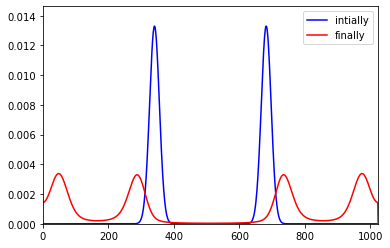

In [3]:
    plt.plot(np.square(abs(initial_state)),'b')
    finalstate = sim_sv(qc,'\psi')
    plt.plot(np.square(abs(finalstate)),'r')
    plt.axis([0, 2**n-1, 0, 1.1*max(np.square(abs(initial_state)))])
    plt.legend(["intially", "finally"])